In [ ]:
import Pkg
Pkg.activate("..\\..\\juMLia")
using Plots, Random, LinearAlgebra, Distances

  Activating project at `d:\Users\gabri\Documents\Data Science & Machine Learning Spring 2025\Lundquist-CMOR438-Spring2025\juMLia`


In [2]:
function makeblobs(nsamples, nfeatures, ncenters; centerseparation=10, clusterspread=1, randomstate=0)
    Random.seed!(randomstate)
    pointspercluster = div(nsamples, ncenters)
    X = Array{Float64}(undef, 0, nfeatures)
    y = Int[]
    clusters = Vector{Array{Float64,2}}(undef, ncenters)

    for i in 1:ncenters
        # Randomly place cluster centers
        center = rand(Float64, nfeatures) .* centerseparation
        # Generate points around each center
        clusters[i] = clusterspread .* randn(pointspercluster, nfeatures) .+ center'
        X = vcat(X, clusters[i])
        append!(y, fill(i, pointspercluster))
    end

    return X, y, clusters
end


makeblobs (generic function with 1 method)

DBSCAN is a little hardier than K-Means, so we'll try using it on a 3D dataset that's very difficult to linearly separate.

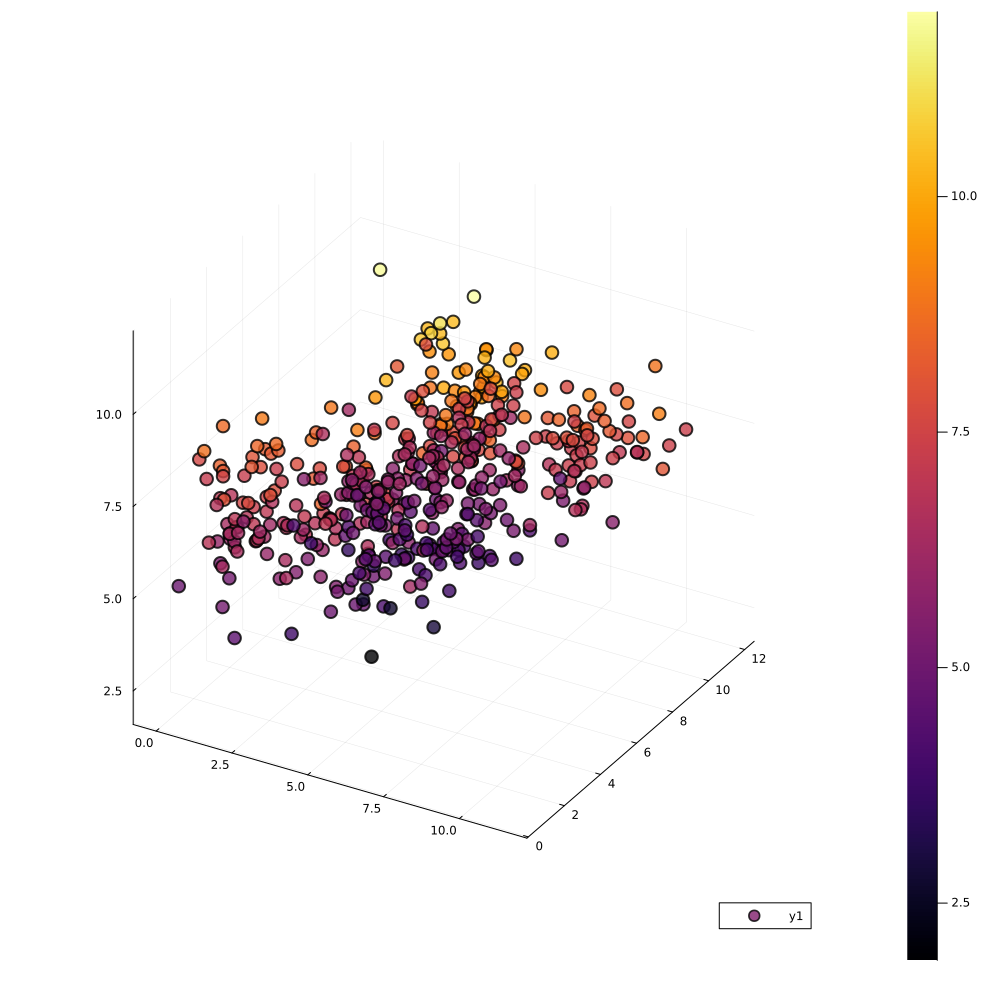

In [3]:
(points, labels, clusters) = makeblobs(500, 3, 7; centerseparation=10, randomstate=34)
scatter(points[:,1], points[:,2], points[:,3], m = (7, 0.8), zcolor = points[:,3], size = (1000, 1000))

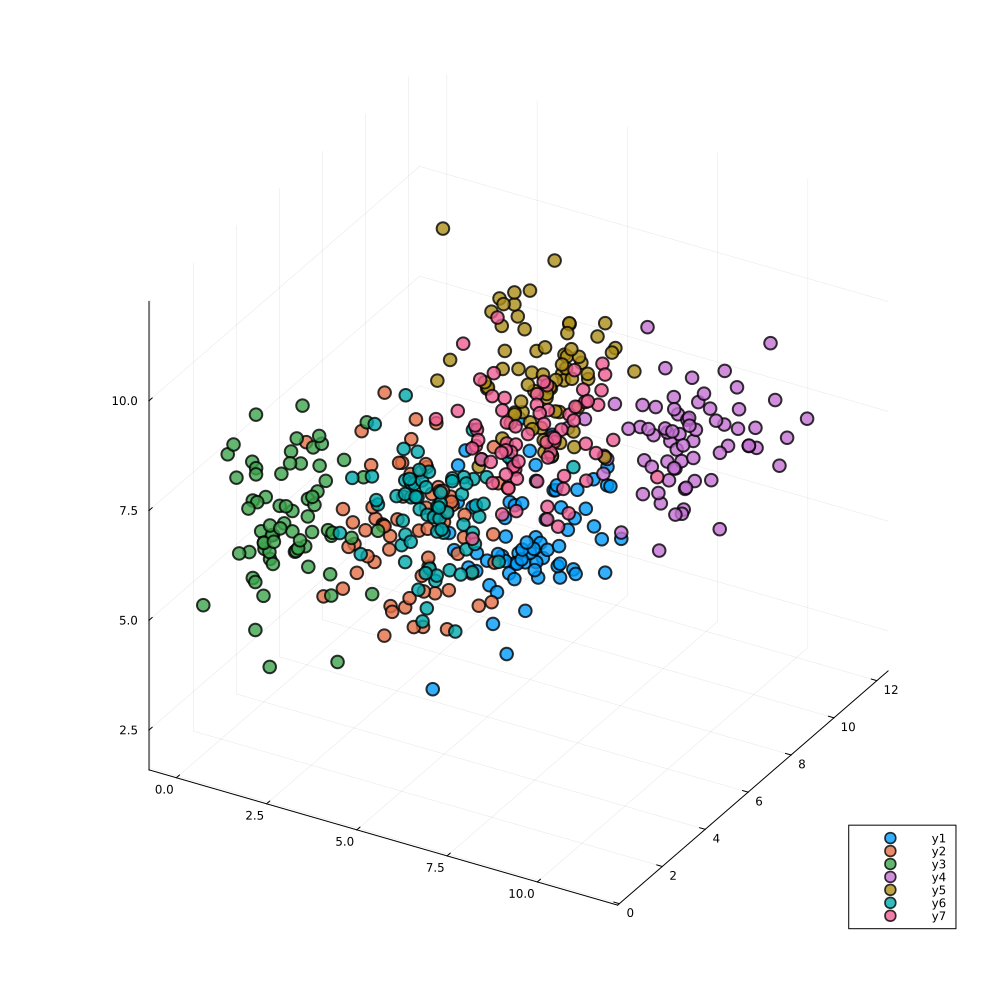

In [4]:
plot()
for cluster in clusters
    scatter!(cluster[:,1], cluster[:,2], cluster[:,3], m = (7, 0.8), size = (1000,1000))
end
plot!()

Our first task is to identify all the points within proximity (within a distance of $\epsilon$) of each point.

In [17]:
function proximalpoints(point, allpoints, ϵ; distmetric=norm)
    proximities = Array{Float64}(undef, 0, size(allpoints,2))
    for ptidx in 1:size(allpoints,1)
        ptdistance = distmetric(allpoints[ptidx, :] .- point)
        if ptdistance < ϵ && ptdistance != 0
            proximities = vcat(proximities, allpoints[ptidx, :]')
        end
    end
    return proximities
end

function proximalpoints(points, ϵ; distmetric=norm) 
    return [proximalpoints(points[i,:], points, ϵ; distmetric=distmetric) for i in 1:size(points,1)]
end

proximalpoints (generic function with 2 methods)

In [27]:
proximalpoints(points[28,:], points, 0.5)

2×3 Matrix{Float64}:
 4.9978  8.59542  4.11112
 5.0757  8.15575  4.22009

In [ ]:
Next we have to identify the core points. We just count how many proximal points that each point has and compare it to $k$.

In [ ]:
function corepoints(points, ϵ, k; distmetric=norm)
    proxpoints = proximalpoints(points, ϵ; distmetric=distmetric)
    cores = Array{Float64}(undef, 0, size(points,2))
    coreindices = []
    for ptidx in 1:size(points,1)
        if size(proxpoints[ptidx], 1) >= k
            cores = vcat(cores, points[ptidx,:]')
            push!(coreindices, ptidx)
        end
    end
    return (cores, coreindices, proxpoints)
end

corepoints (generic function with 1 method)

In [94]:
(cores, coreidx, proxpts) = corepoints(points, 0.5, 4)

([5.75852717334076 8.797401736868519 5.110243350219102; 4.821759116788405 9.308485020380793 6.079305980233423; … ; 4.361920015781928 8.301767646286617 6.171230770869415; 4.61443531647384 8.103677376009967 6.425072157368871], Any[40, 70, 103, 121, 147, 149, 160, 170, 174, 177, 180, 191, 203, 237, 328, 378, 392, 399, 452, 478], [[5.761778433506441 7.4432533406169465 5.656801765628415; 5.432064684666489 6.905108530200259 5.1201465468643335; 5.9246348249349525 6.608660747144677 5.38030577774998], Matrix{Float64}(undef, 0, 3), Matrix{Float64}(undef, 0, 3), Matrix{Float64}(undef, 0, 3), [2.7444662584995254 8.251702790494077 3.8998130737356895], [4.502960914927597 7.944210045749094 6.6816710566639905; 4.61443531647384 8.103677376009967 6.425072157368871], Matrix{Float64}(undef, 0, 3), Matrix{Float64}(undef, 0, 3), Matrix{Float64}(undef, 0, 3), [5.41759769507188 6.679826316706637 4.888673027467282; 5.9246348249349525 6.608660747144677 5.38030577774998]  …  [4.361920015781928 8.301767646286617 

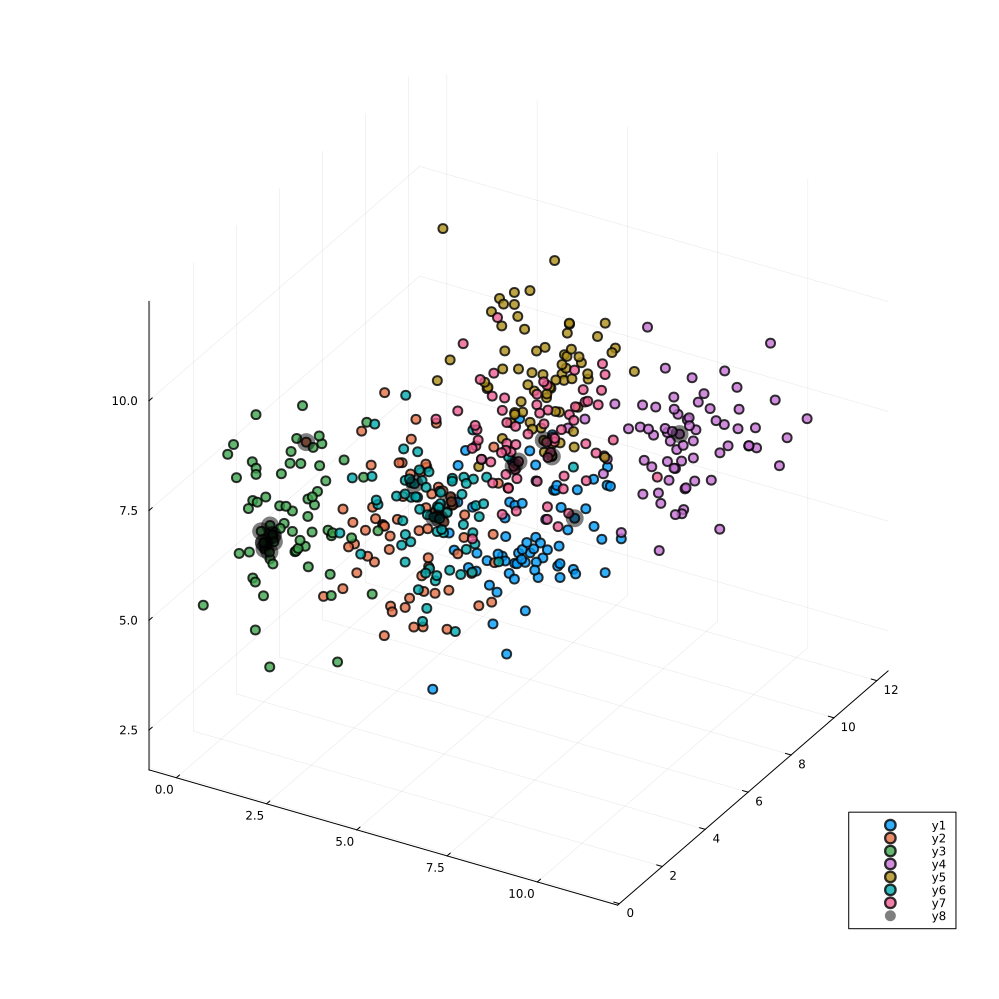

In [95]:
plot()
for cluster in clusters
    scatter!(cluster[:,1], cluster[:,2], cluster[:,3], m = (5, 0.8), size = (1000,1000))
end
scatter!(cores[:,1], cores[:,2], cores[:,3], m = (10, 0.5), mc = "black")

Above we've plotted the identified core points on top of the clusters.

---

Having identified core points we start on the algorithm. The hard part comes from having to identify intersections of the set of core points and each core point's set of proximal points.

In [ ]:
function dbscan(points, ϵ, k; distmetric=norm)
    (cores, coreidx, proxpts) = corepoints(points, ϵ, k)
    clusters = [Matrix{Float64}(undef, 0, size(points, 2))]
    clustersidx = [[]]
    # corevecs = [view(cores, i, :) for i in 1:size(cores,1)]
    coreproxview = view(proxpts, coreidx)
    coreproxptviews = [eachrow(coreproxlist) for coreproxlist in coreproxview]
    corerows = eachrow(cores)
    coreprox = Dict([(corerow, coreproxpts) for (corerow, coreproxpts) in zip(corerows, coreproxptviews)])
    
    c = 1
    clusters[c] = vmat(clusters[c], corerows[1]')
    push!(clustersidx[c], coreidx[1])
    clusters[c] = vmat(clusters[c], stack(coreproxptviews[1] ∩ corerows)')
    push!(clustersidx[c], coreidx[1])
    while !isempty(setdiff(eachrow(clusters[c]), corerows ∩ collect(coreprox(corerow) for corerow in clusters[c])))
    
    for corept in corerows
        btwcoredist = distmetric(corerows[1] .- corept)
        if btwcoredist < ϵ && btwcoredist > 0
            clusters[c] = vmat(clusters[c], corept')
        end
    end
    clustercores = eachrow(clusters[c])
    for corept


    